# SPIE 2020 - Testing Residual Learning in BSD300 dataset with Poisson noise

## Importing libraries

In [3]:
from typing import List, Dict, Tuple
from copy import deepcopy
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from keras import Sequential, layers, activations
from keras.models import Model, load_model
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage.util import random_noise

from images.image import * 
from utils import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading BSD300 Dataset and adding Poisson noise


In [16]:
y_train = []
x_train = []

for file in tqdm(glob(os.path.join('dataset/bsd300/train/*.jpg'))):
  img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

  patches = crop_image(img, height=50, width=50, stride=20)

  for i in range(patches.shape[0]):
    y_train.append(patches[i])
    x_train.append(np.random.poisson(lam=patches[i], size=None))


y_test = []
x_test = []

for file in tqdm(glob(os.path.join('dataset/bsd300/test/*.jpg'))):
  img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

  patches = crop_image(img, height=50, width=50, stride=20)

  for i in range(patches.shape[0]):
    y_test.append(patches[i])
    x_test.append(np.random.poisson(lam=patches[i], size=None))

100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


In [17]:
y_train = np.array(y_train)
x_train = np.array(x_train)

y_test = np.array(y_test)
x_test = np.array(x_test)

In [18]:
x_train.shape

(61600, 50, 50)

In [19]:
x_test.shape

(30800, 50, 50)

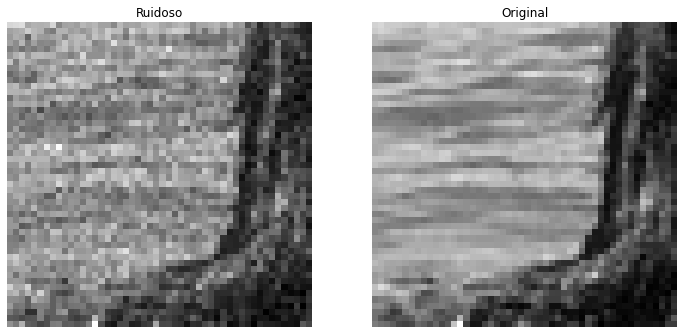

In [21]:
mostrar_lado_a_lado(imagens=[x_train[1500, :,:], y_train[1500,:,:]], titulos=['Ruidoso', 'Original'])

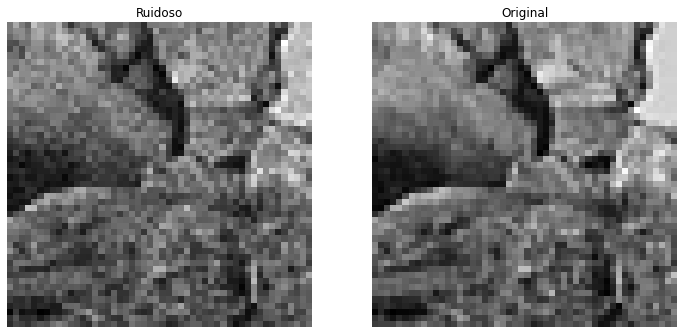

In [22]:
mostrar_lado_a_lado(imagens=[x_test[3010, :,:], y_test[3010,:,:]], titulos=['Ruidoso', 'Original'])

## Normalizing datasets between [0;1]

In [23]:
x_train = cv2.normalize(x_train, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
y_train = cv2.normalize(y_train, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)


x_test = cv2.normalize(x_test, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
y_test = cv2.normalize(y_test, None, alpha= 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

## Adding color dimension

In [24]:
x_train = adiciona_a_dimensao_das_cores(x_train)
y_train = adiciona_a_dimensao_das_cores(y_train)

x_test = adiciona_a_dimensao_das_cores(x_test)
y_test = adiciona_a_dimensao_das_cores(y_test)

In [25]:
x_train.shape

(61600, 50, 50, 1)

In [26]:
x_test.shape

(30800, 50, 50, 1)

# Building model with Residual Learning

In [28]:
model_with_subtract = build_dncnn_model(nb_layers=10, with_subtract=True)
# model_with_subtract.summary()

## Hyper-parameters

In [29]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 60

In [30]:
model_with_subtract.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')

## Saving model checkpoint

In [37]:
checkpoint = keras.callbacks.ModelCheckpoint('checkpoints/dncnn-10l-with-rl-bsd300.hdf5', verbose=1, save_best_only=True, save_weights_only=False, period=1)

# Training the model

In [39]:
history = model_with_subtract.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/60
482/482 [==============================] - ETA: 0s - loss: 0.0134
Epoch 00001: val_loss improved from inf to 0.00163, saving model to checkpoints/dncnn-10l-with-rl-bsd300.hdf5
482/482 [==============================] - 208s 431ms/step - loss: 0.0134 - val_loss: 0.0016
Epoch 2/60
482/482 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00002: val_loss improved from 0.00163 to 0.00124, saving model to checkpoints/dncnn-10l-with-rl-bsd300.hdf5
482/482 [==============================] - 208s 431ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/60
482/482 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00003: val_loss improved from 0.00124 to 0.00114, saving model to checkpoints/dncnn-10l-with-rl-bsd300.hdf5
482/482 [==============================] - 208s 431ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/60
482/482 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00004: val_loss improved from 0.00114 to 0.00091, saving model to che

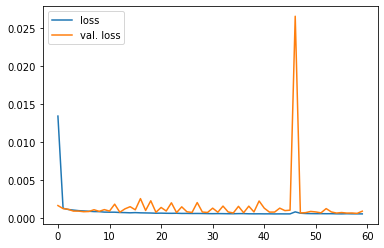

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val. loss'])

# Building the model without RL

In [31]:
model_without_subtract = build_dncnn_model(nb_layers=10, with_subtract=False)
model_without_subtract.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')
checkpoint = keras.callbacks.ModelCheckpoint('checkpoints/dncnn-10l-without-rl-bsd300.hdf5', verbose=1, save_best_only=True, save_weights_only=False, period=1)

In [42]:
hist_without_subtract = model_without_subtract.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    shuffle=True,
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/60
482/482 [==============================] - ETA: 0s - loss: 0.0139
Epoch 00001: val_loss improved from inf to 0.01377, saving model to checkpoints/dncnn-10l-without-rl-bsd300.hdf5
482/482 [==============================] - 208s 432ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 2/60
482/482 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.01377 to 0.00298, saving model to checkpoints/dncnn-10l-without-rl-bsd300.hdf5
482/482 [==============================] - 208s 431ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 3/60
482/482 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00003: val_loss did not improve from 0.00298
482/482 [==============================] - 207s 430ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4/60
482/482 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00004: val_loss did not improve from 0.00298
482/482 [==============================] - 207s 430ms/step - loss: 0.0017 - val_l

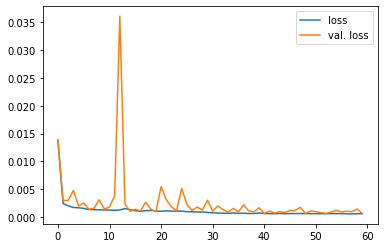

In [43]:
plt.plot(hist_without_subtract.history['loss'])
plt.plot(hist_without_subtract.history['val_loss'])
plt.legend(['loss', 'val. loss'])

# Testing the models

In [32]:
model_with_subtract.load_weights('checkpoints/dncnn-10l-with-rl-bsd300.hdf5')
model_without_subtract.load_weights('checkpoints/dncnn-10l-without-rl-bsd300.hdf5')

## Denoising in test projections

In [33]:
predicted_with_subtract = model_with_subtract.predict(x_test, verbose=2)
predicted_with_subtract.shape

963/963 - 32s


(30800, 50, 50, 1)

In [34]:
predicted_without_subtract = model_without_subtract.predict(x_test, verbose=2)
predicted_without_subtract.shape

963/963 - 32s


(30800, 50, 50, 1)

## Visual comparison

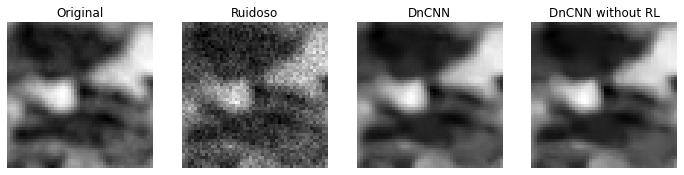

In [35]:
mostrar_lado_a_lado(imagens=[y_test[100,:,:,0], x_test[100,:,:,0], predicted_with_subtract[100,:,:,0], predicted_without_subtract[100,:,:,0]], titulos=['Original', 'Ruidoso', 'DnCNN', 'DnCNN without RL'])

In [36]:
y_test[100].shape

(50, 50, 1)

In [38]:
from denoising.measures import PSNR, SSIM

In [39]:
pnsr_img = PSNR(y_test[100].reshape(1,50,50,1), predicted_with_subtract[100].reshape(1,50,50,1))
ssim_img = SSIM(y_test[100].reshape(1,50,50,1), predicted_with_subtract[100].reshape(1,50,50,1))

print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(pnsr_img).mean(), np.array(ssim_img).mean()))

PSNR médio: 28.84 dB e SSIM médio 0.93.


In [40]:
pnsr_img = PSNR(y_test[100].reshape(1,50,50,1), predicted_without_subtract[100].reshape(1,50,50,1))
ssim_img = SSIM(y_test[100].reshape(1,50,50,1), predicted_without_subtract[100].reshape(1,50,50,1))

print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(pnsr_img).mean(), np.array(ssim_img).mean()))

PSNR médio: 28.28 dB e SSIM médio 0.92.


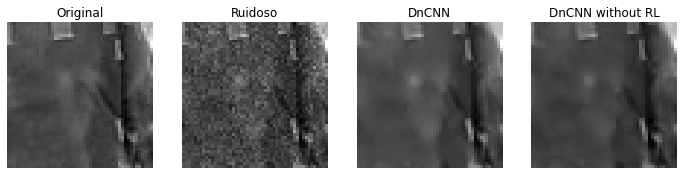

In [41]:
mostrar_lado_a_lado(imagens=[y_test[500,:,:,0], x_test[500,:,:,0], predicted_with_subtract[500,:,:,0], predicted_without_subtract[500,:,:,0]], titulos=['Original', 'Ruidoso', 'DnCNN', 'DnCNN without RL'])

## Compairing PSNR and SSIM of projections filtered by the network

In [42]:
psnr = PSNR(y_test, x_test)
ssim = SSIM(y_test, x_test)

In [43]:
print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(psnr).mean(), np.array(ssim).mean()))

PSNR médio: 19.51 dB e SSIM médio 0.75.


In [44]:
psnr_pred = PSNR(y_test, predicted_with_subtract)
ssim_pred = SSIM(y_test, predicted_with_subtract)

In [45]:
print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(psnr_pred).mean(), np.array(ssim_pred).mean()))

PSNR médio: 25.87 dB e SSIM médio 0.90.


In [46]:
psnr_pred_without_subtract = PSNR(y_test, predicted_without_subtract)
ssim_pred_without_subtract = SSIM(y_test, predicted_without_subtract)

In [47]:
print('PSNR médio: %.2f dB e SSIM médio %.2f.' % (np.array(psnr_pred_without_subtract).mean(), np.array(ssim_pred_without_subtract).mean()))

PSNR médio: 28.82 dB e SSIM médio 0.89.


## PSNR with RL: 25.87 dB

## PSNR without RL: 28.82 dB

## SSIM with RL: 0.90

## SSIM without RL: 0.89

# Saving data

In [49]:
np.save('results/spie2020/teste-rl/poisson/predicted_with_rl.npy', predicted_with_subtract)

In [50]:
np.save('results/spie2020/teste-rl/poisson/predicted_without_rl.npy', predicted_without_subtract)

In [51]:
np.save('results/spie2020/teste-rl/poisson/psnr_with_rl.npy', np.array(psnr_pred))
np.save('results/spie2020/teste-rl/poisson/ssim_with_rl.npy', np.array(ssim_pred))

np.save('results/spie2020/teste-rl/poisson/psnr_without_rl.npy', np.array(psnr_pred_without_subtract))
np.save('results/spie2020/teste-rl/poisson/ssim_without_rl.npy', np.array(ssim_pred_without_subtract))